In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# If you don't have jax-metal properly installed just comment
# out the gpu_device and set device to cpu
gpu_device = jax.devices('METAL')[0]
cpu_device = jax.devices('cpu')[0]
device = gpu_device

# Scalar function of many arguments

Consider the function
$$ f\left(a_1, a_2, x, y\right) = a_1 x^2 + a_2 y^2$$


### Evaluating for scalar arguments
Here is how you compute each of the following derivatived at $a_1=2$, $a_2=3$, $x=4$, $y=5$:
$$\frac{\partial f}{\partial a_1} = x^2 = 4^2 = 16$$
$$\frac{\partial f}{\partial a_2} = y^2 = 4^2 = 25$$
$$\frac{\partial f}{\partial x} = 2 a_1 x = (2)(2)(4) = 16$$
$$\frac{\partial f}{\partial y} = 2 a_2 y = (2)(3)(5) = 30$$

In [9]:
with jax.default_device(device):
    a1, a2 = 2.0, 3.0
    x, y = 4.0, 5.0
    
    
    # Define the function (jit is optional)
    @jax.jit
    def f(a1, a2, x, y):
        return a1 * x**2 + a2 * y**2
    
    
    # Take derivative with respect to first arg
    df_da1 = jax.grad(f, 0)(a1, a2, x, y)
    
    # Can also specify derivative with respect to argnums variable
    df_da2 = jax.grad(f, argnums=1)(a1, a2, x, y)
    
    # Can compute multiple partials at once
    df_dx, df_dy = jax.grad(f, argnums=(2, 3))(a1, a2, x, y)
    
    # Print the results
    print(f"df_da1 = {df_da1}")
    print(f"df_da2 = {df_da2}")
    print(f"df_dx = {df_dx}")
    print(f"df_dy = {df_dy}")

df_da1 = 16.0
df_da2 = 25.0
df_dx = 16.0
df_dy = 30.0


# Loss function for least-squares-like problems

Let's say I wanted to perform a least squared fit to two basis functions.
$$f_1(t) = \sin(t)$$
$$f_2(t) = \cos(t)$$.

I could then write the following loss function
$$L\left(\mathbf y, \mathbf w, \mathbf A \right) = \sum_{i}{\left(y_i - w_1 f_1(t_i) - w_2 f_2(t_i) \right)^2} = \left(\mathbf{y} - \mathbf{A} \mathbf{w}\right)^T \left(\mathbf{y} - \mathbf{A} \mathbf{w}\right)$$
where
$$\mathbf{w} = \begin{bmatrix}
w_1 \\
w_2
\end{bmatrix}$$
and
$$
\mathbf A = \begin{bmatrix}
f_1\left(t_1\right) & f_2\left(t_1\right) \\
... & ... \\
f_1\left(t_N\right) & f_2\left(t_N\right)
\end{bmatrix}
$$



## Gradient of parameters
Lets say I wanted to compute the gradient of the loss function with respect to the parameters
$$\mathbf{g} = \frac{\partial L}{\partial \mathbf{w}} = \begin{bmatrix} \frac{\partial L}{\partial w_1} \\ \frac{\partial L}{\partial w_2} \end{bmatrix} $$

In [10]:
with jax.default_device(device):
    # Make the A matrix
    t = jnp.linspace(0, 2 * jnp.pi, 100)
    f1 = jnp.sin(t)
    f2 = jnp.cos(t)
    A = jnp.stack((f1, f2), axis=1)
    
    # Make the w vector
    w = jnp.array([[2.0], [3.0]])
    
    # Just for an example, let me define y to be a perfect fit
    y = A @ w
    
    # Now let me add a little noise to the perfect fit
    try:
        key = jax.random.split(key)[1]
    except:
        key = jax.random.PRNGKey(1)
    noise_amp = 0.1
    noise = noise_amp * jax.random.normal(key, y.shape)
    y = y + noise
    
    # display(hv.Curve((t, jnp.squeeze(y))))
    
    
    # # Define the loss function
    def L(y, w, A):
        e = y - A @ w
        return jnp.squeeze(e.T @ e)
    
    
    # Now use JAX to get the gradient with respect to the parameters (
    g = jax.grad(L, 1)(y, w, A)
    print(f"g = \n{g}")

g = 
[[-0.29056692]
 [ 0.04126197]]


## Simple gradient descent on the same problem

Now lets use this simple gradient descent algorithm to fit a function.

Gradient descent fit results: w = [2.1024175 2.986372 ]


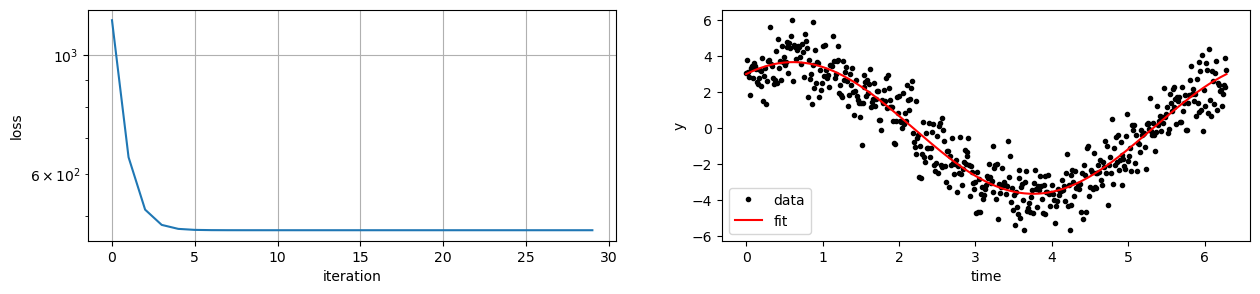

In [11]:
with jax.default_device(device):
    # Make the A matrix
    t = jnp.linspace(0, 2 * jnp.pi, 500)
    f1 = jnp.sin(t)
    f2 = jnp.cos(t)
    A = jnp.stack((f1, f2), axis=1)
    
    # Make the w vector
    w_true = jnp.array([2.0, 3.0])
    
    # Make a "true" y variable
    y = (A @ w_true).squeeze()
    
    # Now let me add a little noise
    try:
        key = jax.random.split(key)[1]
    except:
        key = jax.random.PRNGKey(10)
    
    noise_amp = 1.0
    noise = noise_amp * jax.random.normal(key, y.shape)
    y = y + noise
    
    
    # # Define the loss function
    @jax.jit
    def L(y, w, A, noise_amp):
        """
        Its good to have y and w be squeezed.  Otherwise weird
        things happen to shapes when you try to do hessians
        """
        y = y.reshape(-1, 1)
        w = w.reshape(-1, 1)
        e = (y - A @ w) / noise_amp
        return jnp.squeeze(e.T @ e)
    
    
    # Now use JAX to get the gradient with respect to the parameters (
    gradient = jax.grad(L, 1)
    
    # Run simple gradient descent to find optimal w from random starting place
    learning_rate = 0.001
    key = jax.random.split(key)[1]
    w = jax.random.normal(key, w_true.shape)
    losses = []
    for nn in range(30):
        w = w - learning_rate * gradient(y, w, A, noise_amp).squeeze()
        losses.append(L(y, w, A, noise_amp))
    
    # Compute the best estimate from the learned parameter
    y_hat = A @ w.reshape(-1, 1)
    print(f"Gradient descent fit results: w = {w}")
    
    # Plot the training loss and the final fit
    ax = plt.subplot(
        121,
    )
    ax.plot(np.arange(len(losses)), losses)
    ax.set_xlabel("iteration")
    ax.set_ylabel("loss")
    ax.semilogy(False)
    ax.grid(True)
    ax.axis("tight")
    
    ax = plt.subplot(122)
    ax.plot(t.squeeze(), y.squeeze(), "k.", label="data")
    ax.plot(t.squeeze(), y_hat.squeeze(), "r", label="fit")
    ax.set_xlabel("time")
    ax.set_ylabel("y")
    ax.legend(loc="best")
    
    plt.gcf().set_size_inches(15, 3)

## Use jax to compute the fisher information matrix for determining param uncertainty
There is a cool trick for determing the covariance matrix of parameters estimated from maximum likelihood. Let's define the fisher
information as the hessian the the log likelihood function.  The log-likelihood is

$$L\left(\mathbf y, \mathbf w, \mathbf A \right) = \left(\mathbf{y} - \mathbf{A} \mathbf{w}\right)^T \left(\mathbf{y} - \mathbf{A} \mathbf{w}\right)$$.

The hessian of this function we call the information matrix and write its components as
$$\Lambda_{i, j} = \frac{\partial ^ 2 L}{\partial w_i \partial w_j}$$

The covariance matrix of our fit parameters are the the inverse of the information matrix, or
$$\mathbf \Sigma = \mathbf \Lambda ^{-1}$$


The diagonal elements of this matrix are the uncertainty values of the parameters.  We now use jax to compute the hessian, covariance-matrix and then plot the density functions for the parameters

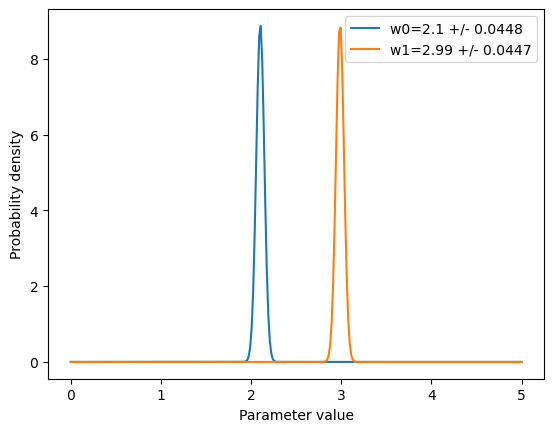

In [12]:
with jax.default_device(device):
    # Use has to compute the hessian matrix evaluated at the
    # best-fit parameters.
    Lambda = jax.hessian(L, argnums=1)(y, w, A, noise_amp)
    
    # Invert the information matrix to get the covariance matrix
    with jax.default_device(cpu_device):
        Sigma = jnp.linalg.inv(Lambda)
    
    # Take the diagonals as the standard deviations for the parameters
    sigma_w = jnp.sqrt(jnp.diag(Sigma))
    
    
    # Plot the density distributions for the parameters
    def plot_param_dist(w, sigma_w):
        x = np.linspace(0, 5, 300)
        w0 = stats.norm.pdf(x, loc=w[0], scale=sigma_w[0])
        w1 = stats.norm.pdf(x, loc=w[1], scale=sigma_w[1])
        ax = plt.subplot(111)
        ax.plot(x, w0, label=f"w0={w[0]:0.3g} +/- {sigma_w[0]:0.3g}")
        ax.plot(x, w1, label=f"w1={w[1]:0.3g} +/- {sigma_w[1]:0.3g}")
        ax.legend(loc="best")
        ax.set_xlabel("Parameter value")
        ax.set_ylabel("Probability density")
    
    
    plot_param_dist(w, sigma_w)


# Find prediction error of the model
We can also use jax to find the prediction error for out model.  Here are the steps.

## Compute the single-datum covariance matrix
Once we find the best value for $\mathbf w$, we can write our estimate as
$$\mathbf{\hat y} = \mathbf{A} \mathbf{w}$$

Now recall that the covariance matrix for our fit was given by the inverse of the information matrix


$$\mathbf \Sigma = \mathbf \Lambda ^{-1}$$
where
$$\Lambda_{i, j} = \frac{\partial ^ 2 L}{\partial w_i \partial w_j}$$

This information matrix above (and the corresponding covariance) describes the parameter uncertainty given all the data.  One can approximate the information coming from each data point as being equal so that the total information matrix is
$$\mathbf \Lambda = \sum_{k=1}^{N} \mathbf \Lambda_k$$

If we only had one data point, then we can approximate its information as
$$\mathbf \Lambda_k = \frac{1}{N} \Lambda$$
and the corresponding single-datum covariance as
$$\mathbf R = \Lambda_k^{-1} = N \mathbf \Lambda^{-1} = N \mathbf \Sigma$$

## Propagate uncertainties through the model function

We can use the standard-deviations on the diagonal of this single-data-point covariance matrix to propagate the resulting uncertainty to the individual data points as follows.

Let's assume that we have a general (possibly non-linear) problem where the solution is given by a model function
$$\mathbf y = \mathbf M \left(\mathbf w, \mathbf x\right)$$.

This is a vector-valued function of two vectors.  We can write the k'th component of the returned vector as 
$$y_k = M_k \left(\mathbf w, \mathbf x\right)$$

We now follow the standard rules of uncertainty propagation to pass the parameter uncertainties through the model
function.
$$\sigma_{k}^2 = \sum_{j}\left(\frac{\partial M_k}{\partial w_j}\right)^2 \sigma_{w_j}^2$$

But, we know from above that the parameter uncertainties for a single datum are
$$\sigma_{w_j}^2 = N \mathbf \Sigma_{j, j}$$
where $N$ is the number of data points we fit the model to.

## Apply this to our specific problem
In our toy problem, we have a two element weight matrix
$$\mathbf{w} = \begin{bmatrix}
w_1 \\
w_2
\end{bmatrix}$$
so
$$\sigma_{k}^2 = \left(\frac{\partial M_k}{\partial w_1}\right) ^ 2 \sigma_{w_1}^2 + \left(\frac{\partial M_k}{\partial w_2}\right) ^ 2 \sigma_{w_2}^2$$


# Jax implementation
The partial derivatives we have above can be assembled into a matrix called the Jacobian matrix with elements
$$J_{j, k} = \frac{\partial M_j}{\partial w_k}$$
Jax knows how to compute Jacobian matrices, but frequently it is not necessary to compute the entire matrix and the less expensive Jacobian-vector product can be computed instead.  

The output of the Jacobian-vector-product is a vector whose elements are
$$y_j = \sum_{k}J_{j, k} v_k$$

for any vector you want, $\mathbf v$.  If I just want the values of the partial derivatives I can let $\mathbf v$ be a vector of all ones.

This is what I do in the jax implementation below.

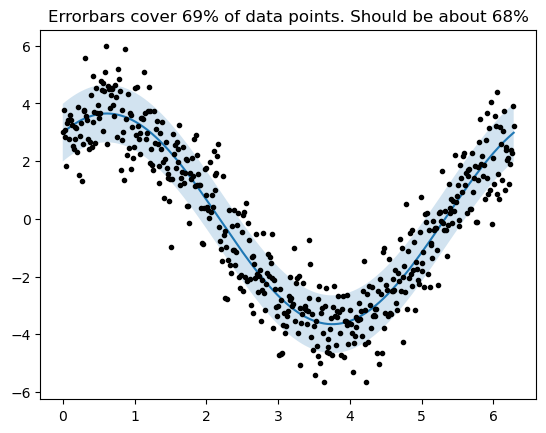

In [13]:
with jax.default_device(device):
    # We define the model function we will use to make our predictions.
    # In our case it's linear, but it won't be in the more general case
    @jax.jit
    def model(A, w):
        return (A @ w).squeeze()
    
    
    # We now take the partial derivatives of each data point with respect to the parameters
    # Lets do the first parameter in detail
    fit, dfit_dw0 = jax.jvp(  # This is the jacobian-vector-product function from jax
        model,  # This is the function on which you're computing the jacobian
        primals=(A, w),  # These are the points at which the jacobian is computed
        tangents=(  # These tangents must be the same shape as the primals.
            jnp.zeros_like(A),  # I don't care about A, so make all the values here zero.
            jnp.array(
                [1.0, 0.0]
            ),  # This is the value I care about so set it to the vector of ones (v in example above)
        ),
    )
    
    # This is exactly the same thing applied to the second parameter
    fit, dfit_dw1 = jax.jvp(
        model, primals=(A, w), tangents=(jnp.zeros_like(A), jnp.array([0.0, 1.0]))
    )
    
    # Do the uncertainty propagation making sure to account for the factor of N=len(fit) in the covariance matrices
    fit_error = jnp.sqrt(len(fit)) * jnp.sqrt(
        (dfit_dw0**2) * sigma_w[0] ** 2 + (dfit_dw1**2) * sigma_w[1] ** 2
    )
    
    # Compute the fraction of data points that fall within the uncertainty band
    in_band_frac = float(
        jnp.sum(jnp.array((y < fit + fit_error) & (y > fit - fit_error), dtype="int32"))
        / len(y)
    )
    
    # Plot the points, the fit, and the fisher-information uncertainty bands
    ax = plt.subplot(111)
    ax.plot(t, fit)
    ax.plot(t, y, ".k")
    # ax.plot(t, fit_error)
    # ax.errorbar(t, fit, yerr=fit_error)
    ax.fill_between(t, fit + fit_error, fit - fit_error, alpha=0.2)
    ax.set_title(
        f"Errorbars cover {int(in_band_frac * 100)}% of data points. Should be about 68%"
    );

In [14]:
import jax.scipy as scp